# Auto Insurance claim prediction

## Data preprocessing

The large size of the original datasets will fail to upload to GitHub later.  Therefore, data preprocessing has been performed in a separated notebook, and the cleaned DataFrame is saved as 'df.csv' ready for use.

### 3 original datasets:
- Traffic Crashes - Crashes
- Traffic Crashes - Vehicles
- Traffic Crashes - People

### Preview and inspect all 3 datasets:
- Inspecting the datasets.
- Based on project assumptions, adjust the DataFrames:
    - From df_crash, select ‘INJURIES_TOTAL’ = ‘0’
    - From df_people, select ‘PERSON_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘UNIT_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘VEHICLE_USE’ = ‘PERSONAL’

- Explore each column and decide what to keep.
- Merge all 3 DataFrames on column 'CRASH_RECORD_ID' and drop all null.
- Convert column 'AGE' and 'VEHICLE_YEAR' Dtype from float64 to int for for smaller data size.
- Save the cleaned DataFrame as 'df.csv'>


## Import libraries and load the cleaned DataFarame

In [1]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

## Inspect and adjust DataFrame

In [11]:
df = pd.read_csv('df_clean.csv')
df.head()

,Unnamed: 0,CRASH_DATE,DAMAGE,ZIPCODE,SEX,AGE,MAKE,MODEL,VEHICLE_YEAR
0,0,09/05/2018 08:40:00 AM,"OVER $1,500",60634,F,39,"TOYOTA MOTOR COMPANY, LTD.",4RUNNER,2002
1,1,09/05/2018 08:40:00 AM,"OVER $1,500",60634,F,39,"TOYOTA MOTOR COMPANY, LTD.",CAMRY,2014
2,2,09/05/2018 08:40:00 AM,"OVER $1,500",60625,M,32,"TOYOTA MOTOR COMPANY, LTD.",4RUNNER,2002
3,3,09/05/2018 08:40:00 AM,"OVER $1,500",60625,M,32,"TOYOTA MOTOR COMPANY, LTD.",CAMRY,2014
4,4,08/29/2022 11:30:00 AM,"$501 - $1,500",60620,F,40,NISSAN,ALTIMA,2017


In [12]:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421414 entries, 0 to 421413
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CRASH_DATE    421414 non-null  object
 1   DAMAGE        421414 non-null  object
 2   ZIPCODE       421414 non-null  int64 
 3   SEX           421414 non-null  object
 4   AGE           421414 non-null  int64 
 5   MAKE          421414 non-null  object
 6   MODEL         421414 non-null  object
 7   VEHICLE_YEAR  421414 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 25.7+ MB


In [13]:
df['DAMAGE'].value_counts(normalize=True)

OVER $1,500      0.636035
$501 - $1,500    0.279431
$500 OR LESS     0.084534
Name: DAMAGE, dtype: float64

### Reset target df['DAMAGE'] from 3 outcomes to 2 outcomes

- OVER 1,500 = 1
- 501 - 1,500 = 1
- 500 OR LESS = 0

In [106]:
# In df['DAMAGE'], replace '$501 - $1,500' and 'OVER $1,500' with 'Over $500':
df_main = df.copy()
df_main['DAMAGE'] = df_main['DAMAGE'].replace(['$501 - $1,500', 'OVER $1,500'], 1)
df_main['DAMAGE'] = df_main['DAMAGE'].replace(['$500 OR LESS'], 0)

In [107]:
df_main['DAMAGE'].value_counts(normalize=True)

1    0.915466
0    0.084534
Name: DAMAGE, dtype: float64

### Reset date range for smaller size and drop 'CRASH_DATE' and 'ZIPCODE'

In [37]:
# Select date range starting from 12/15/2021:

df_main =df_main[df_main['CRASH_DATE'] >= '12/15/2021']

In [108]:
# Take out 'ZIPCODE' and re-run the models

df_main = df_main.drop(['CRASH_DATE', 'ZIPCODE'], axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421414 entries, 0 to 421413
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DAMAGE        421414 non-null  int64 
 1   SEX           421414 non-null  object
 2   AGE           421414 non-null  int64 
 3   MAKE          421414 non-null  object
 4   MODEL         421414 non-null  object
 5   VEHICLE_YEAR  421414 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 19.3+ MB


In [39]:
# Checking Null:

df_main.isna().sum()

DAMAGE          0
SEX             0
AGE             0
MAKE            0
MODEL           0
VEHICLE_YEAR    0
dtype: int64

In [40]:
# Checking memory usage:

df_main.memory_usage(deep=True)

Index            246688
DAMAGE          1911832
SEX             1911832
AGE              246688
MAKE            2026046
MODEL           2026169
VEHICLE_YEAR     246688
dtype: int64

## Prepare for modeling

### Define X and y, perform train_test_split

In [41]:
# define X and y:

X = df_main.drop('DAMAGE', axis=1)
y = df_main['DAMAGE']

# train_test_split:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Using Pipeline and FunctionTransformer

In [43]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int64'])

In [44]:
# The FunctionTransformer will turn my function into a transformer:

GrabNumeric = FunctionTransformer(grab_numeric)

In [45]:
# Pipe:

pipe = Pipeline([
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

In [46]:
# checking the resualt:

pipe.fit_transform(X_train)

array([[-0.78805163, -0.13444896],
       [-0.72157583,  1.87908587],
       [-0.32272106,  0.20114018],
       ...,
       [ 1.40564962,  1.87908587],
       [ 0.40851269, -0.97342181],
       [-1.38633379, -0.13444896]])

### Using Pipeline and ColumnTransformer


#### We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical

- numbers (AGE, VEHICLE_YEAR)
 - scale, impute

- categorical (all other columuns)
 - OHE, impute

In [47]:
# Numeric pipeline:

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

In [48]:
# Categorical pipeline:

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Selector and ColumnTransformer
This will return a callable list of columns

In [49]:
# The "remainder='passthrough" tells the compiler to leave the other df columns unchanged.
# The `ColumnTransformer` will take care of our preprocessing, so now we can add our model at the end of the pipeline:

CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include='int64')),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

In [50]:
# testing Selector:

test = selector(dtype_include='int64')
test(X_train)

['AGE', 'VEHICLE_YEAR']

## Bringing in Our Modeling Class from before

In [51]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        
        # Validate score on test data
        self.cv_results_test = cross_val_score(self.model, X_test, y_test, cv=kfolds)
        self.cv_test_mean = np.mean(self.cv_results_test)
        
    def print_cv_summary(self):
        cv_summary = self.cv_mean
        return cv_summary
        
#         cv_summary = (
#         f'''CV Results for `{self.name}` model:
#             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
#         ''')
#         print(cv_summary)


    def print_cv_test_summary(self):
        cv_test_summary = self.cv_test_mean
        return cv_test_summary


    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Models

### Model 1: Create Baseline Model - Dummy Classifier Model

In [52]:
dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [53]:
# Use the class without dummy pipe:

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy', X = X_train, y = y_train)

In [54]:
# Score on training data:

dummy_score_train = dummy_model_pipe.print_cv_summary()
dummy_score_train

0.9113590141175871

In [55]:
# Validate with testing data:

dummy_score_test = dummy_model_pipe.print_cv_test_summary()
dummy_score_test

0.9050460693651354

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

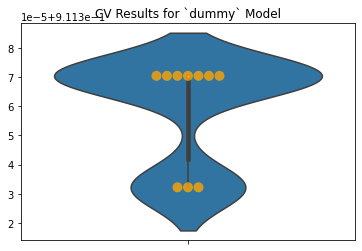

In [56]:
fig,ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

### Model 2: Create FSM (First Simple Model) - Logistic Regression Model

In [57]:
# Reset solver from 'lbfgs' to 'saga', and max_iter = 300

logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42, solver='saga', max_iter=300))
])

In [58]:
# Use the class with out logreg pipe

fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)

# Getting ConvergenceWarning. Go back to logreg_fsm above to reset the parameters.

In [59]:
# Score on training data:

logreg_score_train = fsm_model_pipe.print_cv_summary()
logreg_score_train

0.9114887345034909

In [60]:
# Validate with testing data:

logreg_score_test = fsm_model_pipe.print_cv_test_summary()
logreg_score_test

0.9050460693651354

<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

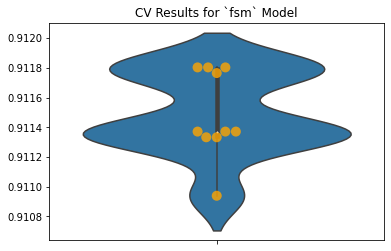

In [61]:
fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

### Trying Other Models at the End of the Pipeline
### Model 3: Random Forest

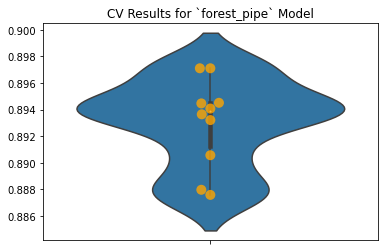

In [62]:
# rfc!
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [63]:
# Score on training data:

rfc_score_train = forest_pipe.print_cv_summary()
rfc_score_train

0.8930252058097977

In [64]:
# Validate with testing data:

rfc_score_test = forest_pipe.print_cv_test_summary()
rfc_score_test

0.8862359560024929

### Model 4: Gradient Booster

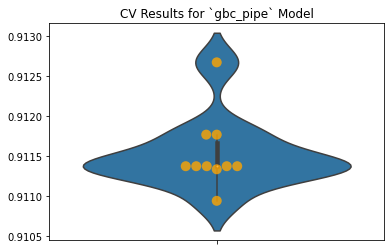

In [65]:
# gbc!
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_pipe = ModelWithCV(model=gbc_model_pipe,
                          model_name='gbc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax=ax);

In [66]:
# Score on training data:

gbc_score_train = gbc_pipe.print_cv_summary()
gbc_score_train

0.9115319870986465

In [67]:
# Validate with testing data:

gbc_score_test = gbc_pipe.print_cv_test_summary()
gbc_score_test

0.9027111021274445

## Take out column 'ZIPCODE' and re-run the models
It took 1h 32mins to excute Gradient Booster model.
Decided to take out Column 'ZIPCODE' since this dataset is collected in Chicago. Different 'ZIPCODE' might not impact the target much.

Before taking out ‘ZIPCODE’:
- CV Results for `dummy` model:  0.63879 ± 0.00009 accuracy
- CV Results for `forest_pipe` model:  0.62870 ± 0.00595 accuracy
- CV Results for `gbc_pipe` model:  0.63943 ± 0.00072 accuracy


### Model 5: Decision Tree

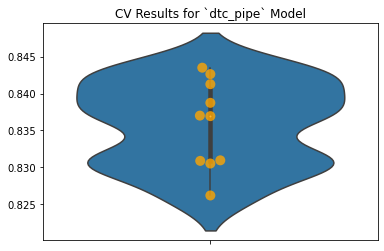

In [68]:
dtc_model_pipe = Pipeline([('ct', CT), ('dtc', DecisionTreeClassifier(random_state=42))])

dtc_pipe = ModelWithCV(model=dtc_model_pipe,
                          model_name='dtc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

dtc_pipe.plot_cv(ax=ax);

In [69]:
# Score on training data:

dtc_score_train = dtc_pipe.print_cv_summary()
dtc_score_train

0.8358629089081273

In [70]:
# Validate with testing data:

dtc_score_test = dtc_pipe.print_cv_test_summary()
dtc_score_test

0.8277329155928378

### Model 6: Tuning and Cross-Validating - Logistic Regression Model

As a result, Logistic Regression Model has the best accuracy. Tune the Logreg Model and perform GridSearch:

In [86]:
# Checking logreg Pipeline:

logreg_fsm

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000012791B8A220>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [87]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'logreg_fsm__max_iter':[500, 600],
    'logreg_fsm__class_weight':[None, 'balanced']
}

# Set up GridSearchCV and fit training data:
gs_logreg = GridSearchCV(estimator=logreg_fsm, param_grid=params, cv=10, verbose=2)

gs_logreg.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  11.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  10.9s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  10.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  11.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  10.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, tot

[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=   7.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=   7.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  11.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  11.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logre

[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=   7.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=   8.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=   8.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=   7.8s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 12.5min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000012791B8A220>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [88]:
gs_logreg.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'logreg_fsm__class_weight': None,
 'logreg_fsm__max_iter': 500}

In [89]:
tunedLogreg_score_train = gs_logreg.best_score_
tunedLogreg_score_train

0.9114887345034909

In [90]:
# Validate with testing data:
tunedLogreg_score_test = gs_logreg.best_estimator_.score(X_test, y_test)
tunedLogreg_score_test

0.9049163315605137

### Model 7: Tuning and Cross-Validating - Random Forest Model

In [71]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'rfc__criterion':['gini','entropy'],
    'rfc__max_depth':[1,3,5]
}

# Set up GridSearchCV and fit training data:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10, verbose=2)

gs_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gi

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__st

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   2.1s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   2.1s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.0min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000012791B8A220>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [72]:
gs_rfc.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'rfc__criterion': 'gini',
 'rfc__max_depth': 1}

In [73]:
tunedRfc_score_train = gs_rfc.best_score_
tunedRfc_score_train

0.9113590141175871

In [74]:
# Validate with testing data:
tunedRfc_score_test = gs_rfc.best_estimator_.score(X_test, y_test)
tunedRfc_score_test

0.9050460500713452

## Imblearn Pipelines
Dealing with the Target Imbalance, let's use SMOTE.

In [75]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [76]:
# To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

X_train_clean = X_train.select_dtypes('int64').dropna()
y_train_clean = y_train[X_train_clean.index]

In [77]:
y_train_clean

254058    1
395530    1
38984     1
95719     1
316284    1
         ..
416463    1
83974     1
22656     1
219809    1
325375    1
Name: DAMAGE, Length: 23127, dtype: object

In [78]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

0    21077
1    21077
Name: DAMAGE, dtype: int64

### Model 8: ImPipleline with SMOTE (sampling_strategy='auto') and Random Forest Model

In [79]:
# imbpipe!

imb_pipe= ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
])

imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000012791B8A220>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [80]:
imbRfc_score_train = imb_pipe.score(X_train, y_train)
imbRfc_score_train

0.9904008301984694

In [81]:
# Validate with testing data:
imbRfc_score_test = imb_pipe.score(X_test, y_test)
imbRfc_score_test

0.8425217278505642

### Model 8-1: ImPipleline with SMOTE (sampling_strategy=0.8) and Random Forest Model

In [82]:
imb_pipe80= ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(sampling_strategy=0.8, random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
])

imb_pipe80.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000012791B8A220>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [83]:
imbRfc80_score_train = imb_pipe.score(X_train, y_train)
imbRfc80_score_train

0.9904008301984694

In [84]:
# Validate with testing data:
imbRfc80_score_test = imb_pipe.score(X_test, y_test)
imbRfc80_score_test

0.8425217278505642

### Model 9: Gridsearching with SMOTE and Random Forest Model

In [91]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 3],
          'sm__k_neighbors': [3, 5]}

gs_smote_rfc = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10, verbose=2)

gs_smote_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  29.7s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.6s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  29.7s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  28.6s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  29.0s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  31.7s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  29.7s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  29.4s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighb

[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  32.5s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  32.5s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  31.9s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  31.4s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  30.2s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  30.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=3, sm__k_neighbors=3 
[CV]  rfc__criterion=entropy, rfc_

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 39.7min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000012791B8A220>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [92]:
gs_smote_rfc.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 3}

In [93]:
gsRfc_score_train = gs_smote_rfc.score(X_train, y_train)
gsRfc_score_train

0.9904440697020798

In [94]:
# Validate with testing data:
gsRfc_score_test = gs_smote_rfc.score(X_test, y_test)
gsRfc_score_test

0.8480996238163185

## Evaluation and Final Model

### Bring the scores together from all models:

In [95]:
model_list = ['dummy', 'logreg', 'rfc', 'gbc', 'dtc', 'tunedLogreg', 'tunedRfc', 'imbRfc', 'gsRfc']

score_train_list = [] 
score_test_list = []

for i in model_list:
    score_train_list.append(eval(i+'_score_train'))
    score_test_list.append(eval(i+'_score_test'))


In [96]:
df_score_train = pd.DataFrame (score_train_list, columns = ['score_train'], index=model_list)
df_score_test = pd.DataFrame (score_test_list, columns = ['score_test'], index=model_list)
df_score = pd.concat([df_score_train, df_score_test], axis=1)


df_score

,score_train,score_test
dummy,0.911359,0.905046
logreg,0.911489,0.905046
rfc,0.893025,0.886236
gbc,0.911532,0.902711
dtc,0.835863,0.827733
tunedLogreg,0.911489,0.904916
tunedRfc,0.911359,0.905046
imbRfc,0.990401,0.842522
gsRfc,0.990444,0.848100


In [97]:
df_score['difference'] = df_score['score_test']-df_score['score_train']
df_score

,score_train,score_test,difference
dummy,0.911359,0.905046,-0.006313
logreg,0.911489,0.905046,-0.006443
rfc,0.893025,0.886236,-0.006789
gbc,0.911532,0.902711,-0.008821
dtc,0.835863,0.827733,-0.008130
tunedLogreg,0.911489,0.904916,-0.006572
tunedRfc,0.911359,0.905046,-0.006313
imbRfc,0.990401,0.842522,-0.147879
gsRfc,0.990444,0.848100,-0.142344


### Score DataFrame:

In [98]:
df_score['fitting'] = np.where(df_score['difference'] < 0, "over fitting", "under fitting")
df_score

,score_train,score_test,difference,fitting
dummy,0.911359,0.905046,-0.006313,over fitting
logreg,0.911489,0.905046,-0.006443,over fitting
rfc,0.893025,0.886236,-0.006789,over fitting
gbc,0.911532,0.902711,-0.008821,over fitting
dtc,0.835863,0.827733,-0.008130,over fitting
tunedLogreg,0.911489,0.904916,-0.006572,over fitting
tunedRfc,0.911359,0.905046,-0.006313,over fitting
imbRfc,0.990401,0.842522,-0.147879,over fitting
gsRfc,0.990444,0.848100,-0.142344,over fitting


## Final Model!

In [99]:
final_model = gs_smote_rfc

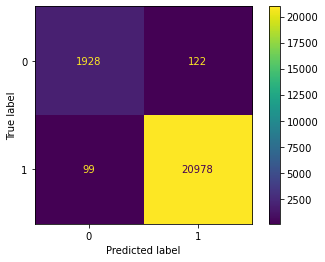

In [100]:
plot_confusion_matrix(final_model, X_train, y_train);

In [111]:
y_hat = final_model.predict(X_train)

In [112]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train, y_hat), 2)}.
""")

C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:


ValueError: pos_label=1 is not a valid label: array(['0', '1'], dtype='<U1')

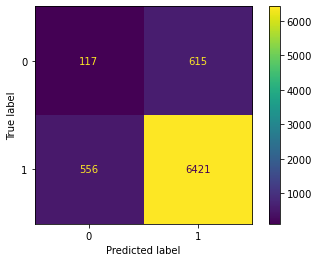

In [113]:
plot_confusion_matrix(final_model, X_test, y_test);

In [ ]:
y_hat = final_model.predict(X_test)